https://www.kaggle.com/competitions/new-york-city-taxi-fare-prediction/data

* 필사 출처
https://www.kaggle.com/code/madhurisivalenka/cleansing-eda-modelling-lgbm-xgboost-starters

## Data

In [1]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt 
import os

In [2]:
# train 100만개만
train = pd.read_csv("data/taxi/train.csv", nrows=1000000)
print(train.shape)
train.head(2)

(1000000, 8)


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1


In [3]:
test = pd.read_csv("data/taxi/test.csv")
print(test.shape)
test.head(2)

(9914, 7)


,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1


In [4]:
# info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 8 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   key                1000000 non-null  object 
 1   fare_amount        1000000 non-null  float64
 2   pickup_datetime    1000000 non-null  object 
 3   pickup_longitude   1000000 non-null  float64
 4   pickup_latitude    1000000 non-null  float64
 5   dropoff_longitude  999990 non-null   float64
 6   dropoff_latitude   999990 non-null   float64
 7   passenger_count    1000000 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 61.0+ MB


In [5]:
# 수치변수 기술통계
train.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1000000.000000,1000000.000000,1000000.000000,999990.000000,999990.000000,1000000.000000
mean,11.348079,-72.526640,39.929008,-72.527860,39.919954,1.684924
std,9.822090,12.057937,7.626154,11.324494,8.201418,1.323911
min,-44.900000,-3377.680935,-3116.285383,-3383.296608,-3114.338567,0.000000
25%,6.000000,-73.992060,40.734965,-73.991385,40.734046,1.000000
50%,8.500000,-73.981792,40.752695,-73.980135,40.753166,1.000000
75%,12.500000,-73.967094,40.767154,-73.963654,40.768129,2.000000
max,500.000000,2522.271325,2621.628430,45.581619,1651.553433,208.000000


In [6]:
# train 결측치 확인
train.isnull().sum().sort_values(ascending=False)

dropoff_longitude    10
dropoff_latitude     10
key                   0
fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
passenger_count       0
dtype: int64

In [7]:
# test 결측치 확인
test.isnull().sum()

key                  0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64

In [8]:
# drop the missing values
train = train.drop(train[train.isnull().any(1)].index, axis=0)

In [9]:
train.shape

(999990, 8)

In [10]:
test.shape

(9914, 7)

### fare_amount

In [11]:
# check the target column
train["fare_amount"].describe()

count    999990.000000
mean         11.347953
std           9.821790
min         -44.900000
25%           6.000000
50%           8.500000
75%          12.500000
max         500.000000
Name: fare_amount, dtype: float64

In [12]:
# "fare_amount" 중 음수 count
from collections import Counter
Counter(train["fare_amount"]<0)

Counter({False: 999952, True: 38})

In [13]:
# "fare_amount" 중 음수 drop
train = train.drop(train[train["fare_amount"]<0].index, axis=0)
train.shape

(999952, 8)

In [14]:
# no more negative values in th fare field
train["fare_amount"].describe()

count    999952.000000
mean         11.348616
std           9.821249
min           0.000000
25%           6.000000
50%           8.500000
75%          12.500000
max         500.000000
Name: fare_amount, dtype: float64

In [15]:
# 가장 높은 요금은 500달러
train["fare_amount"].sort_values(ascending=False).head(1)

101885    500.0
Name: fare_amount, dtype: float64

### passenger

In [16]:
# "passenger" 기술통계값
train["passenger_count"].describe()

count    999952.000000
mean          1.684942
std           1.323908
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max         208.000000
Name: passenger_count, dtype: float64

In [17]:
# "passenger" unique 값 확인
train["passenger_count"].unique()

array([  1,   2,   3,   6,   5,   4,   0, 208])

In [18]:
# 승객을 208명이나 태운게 말이 안됨 -> 몇개의 데이터인지 확인
train[train["passenger_count"] ==208]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
929022,2009-07-30 11:54:00.000000193,3.3,2009-07-30 11:54:00 UTC,0.0,0.0,0.0,0.0,208


In [19]:
# 1개밖에 안됨 이상치 맞는 것 같음 -> 제거
train = train.drop(train[train["passenger_count"]==208].index, axis=0)
train.shape

(999951, 8)

In [20]:
# 이상치 제거한뒤 기술통계 다시 확인
train["passenger_count"].describe()

count    999951.000000
mean          1.684736
std           1.307733
min           0.000000
25%           1.000000
50%           1.000000
75%           2.000000
max           6.000000
Name: passenger_count, dtype: float64

### latitude & longitude

* latitudes range : -90~90
* longitudes range : -180~180

In [21]:
# 위도 기술통계
train["pickup_latitude"].describe()

count    999951.000000
mean         39.929090
std           7.626025
min       -3116.285383
25%          40.734965
50%          40.752695
75%          40.767154
max        2621.628430
Name: pickup_latitude, dtype: float64

In [22]:
# 범위 벗어나는 위도 확인 
drop1 = train[train["pickup_latitude"]< -90]
drop2 = train[train["pickup_latitude"]> 90]
display(drop1)
display(drop2)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
150559,2012-08-03 07:43:00.000000176,25.3,2012-08-03 07:43:00 UTC,0.000000,-3116.285383,-73.953600,40.787998,1
436233,2012-03-11 01:56:00.000000100,4.1,2012-03-11 01:56:00 UTC,-2986.242495,-880.627428,-3383.296608,-2559.748913,1
543001,2011-10-28 13:53:00.000000178,5.3,2011-10-28 13:53:00 UTC,-3377.680935,-113.019497,-554.918693,314.794180,1


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
5686,2011-07-30 11:15:00.00000082,3.3,2011-07-30 11:15:00 UTC,-73.947235,401.083332,-73.951392,40.778927,1
174356,2011-11-21 21:36:00.00000081,9.7,2011-11-21 21:36:00 UTC,2140.601160,1703.092772,-1251.195890,-1189.615440,1
272439,2011-04-23 02:55:00.00000012,9.3,2011-04-23 02:55:00 UTC,-74.002497,405.350000,-73.978600,40.739962,1
464025,2012-03-05 20:58:00.0000009,6.9,2012-03-05 20:58:00 UTC,-73.994268,404.966667,-73.973857,40.755457,1
505229,2012-03-05 21:08:00.0000006,9.3,2012-03-05 21:08:00 UTC,-73.994268,404.966667,-73.986387,40.776895,1
505583,2012-03-16 08:13:00.000000272,8.5,2012-03-16 08:13:00 UTC,-73.994277,405.133332,-73.956763,40.783737,1
688685,2012-03-22 21:40:00.000000188,17.3,2012-03-22 21:40:00 UTC,2522.271325,2621.628430,-1718.117653,-2864.471003,1
708059,2012-05-24 22:44:00.00000088,5.3,2012-05-24 22:44:00 UTC,-73.989188,91.266667,-73.982362,40.763105,1
970268,2012-04-12 07:31:00.00000027,5.7,2012-04-12 07:31:00 UTC,-73.957087,424.083332,-73.968312,40.765117,1


In [23]:
# 이상치 제거
train = train.drop(drop1.index, axis=0)
train = train.drop(drop2.index, axis=0)
train.shape

(999939, 8)

In [24]:
# 경도 기술통계
train["pickup_longitude"].describe()

count    999939.000000
mean        -72.525443
std          10.692752
min       -1452.988333
25%         -73.992060
50%         -73.981792
75%         -73.967095
max          40.850357
Name: pickup_longitude, dtype: float64

In [25]:
# 범위 벗어나는 경도 확인
drop3 = train[train["pickup_longitude"]< -180]
drop4 = train[train["pickup_longitude"]> 180]
display(drop3)
display(drop4)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
60442,2012-01-12 13:36:00.000000186,4.9,2012-01-12 13:36:00 UTC,-736.550000,40.738230,-73.988742,40.748847,1
217355,2012-06-03 23:21:00.00000077,6.1,2012-06-03 23:21:00 UTC,-740.000000,40.747620,0.000000,0.000000,6
243342,2012-08-02 10:38:00.000000111,7.3,2012-08-02 10:38:00 UTC,-736.333333,40.766480,-73.987928,40.751742,3
351119,2012-02-03 07:53:00.000000135,4.1,2012-02-03 07:53:00 UTC,-736.483332,40.766512,-73.981992,40.771672,1
370663,2012-05-04 23:19:00.000000261,6.1,2012-05-04 23:19:00 UTC,-736.516667,40.719095,-74.003952,40.729860,1
416859,2012-07-21 15:23:00.00000093,6.5,2012-07-21 15:23:00 UTC,-736.416665,40.752285,-73.992565,40.742687,1
568830,2013-05-23 15:23:00.0000007,11.5,2013-05-23 15:23:00 UTC,-735.888333,40.760863,-73.989835,40.738443,5
675500,2011-10-28 10:53:00.00000080,16.9,2011-10-28 10:53:00 UTC,-1452.988333,40.776000,-73.989487,40.740667,2
837619,2012-07-17 08:38:00.000000116,39.7,2012-07-17 08:38:00 UTC,-736.000000,40.758507,0.000000,0.000000,5
914435,2012-03-04 00:10:00.000000131,11.7,2012-03-04 00:10:00 UTC,-736.250000,40.788027,-73.990812,40.750942,1


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count


In [26]:
# 이상치 제거
train = train.drop(drop3.index, axis=0)

In [27]:
train.shape

(999928, 8)

In [28]:
# 마찬가지 방법으로 dropoff 경도/위도도 이상치 제거
drop5 = train[train["dropoff_latitude"]< -90]
drop6 = train[train["dropoff_latitude"]> 90]
display(drop5)
display(drop6)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
579901,2013-08-14 20:23:00.000000245,18.0,2013-08-14 20:23:00 UTC,-73.99919,40.7202,-0.36,-3114.338567,1


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
92310,2011-09-27 11:54:00.000000127,28.9,2011-09-27 11:54:00 UTC,-74.014595,40.681880,-73.973310,404.616667,1
181973,2012-01-03 09:04:00.000000130,6.5,2012-01-03 09:04:00 UTC,-74.008918,40.717827,-74.000855,404.133332,1
335675,2012-02-26 00:25:00.00000085,19.3,2012-02-26 00:25:00 UTC,-74.006457,40.743865,-73.981283,404.133332,1
561910,2010-08-14 03:42:59.0000001,4.5,2010-08-14 03:42:59 UTC,-73.977635,40.754687,-73.870432,405.650000,1
582110,2012-05-02 14:20:00.000000131,30.5,2012-05-02 14:20:00 UTC,-73.870875,40.773792,-73.977790,404.716667,1
748464,2013-01-02 11:33:00.00000020,15.0,2013-01-02 11:33:00 UTC,-74.015200,40.709665,-40.719295,1651.553433,5
889704,2012-05-21 12:15:00.00000098,15.3,2012-05-21 12:15:00 UTC,-74.001292,40.727560,-73.953047,404.466667,1


In [29]:
train = train.drop(drop5.index, axis=0)
train = train.drop(drop6.index, axis=0)
train.shape

(999920, 8)

In [30]:
drop_do_lon1 = train[train["dropoff_longitude"]<-180]
drop_do_lon2 = train[train["dropoff_longitude"]>180]
display(drop_do_lon1)
display(drop_do_lon2)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
269695,2012-05-24 09:00:00.000000101,17.7,2012-05-24 09:00:00 UTC,-73.997572,40.720945,-1329.621332,40.773717,1
282374,2011-04-25 13:09:00.000000123,5.7,2011-04-25 13:09:00 UTC,-73.987105,40.755732,-732.600000,40.744832,1
449263,2012-01-28 16:51:00.00000088,6.9,2012-01-28 16:51:00 UTC,-73.983142,40.741987,-736.500000,40.755255,1
472273,2012-02-09 17:42:00.000000250,49.8,2012-02-09 17:42:00 UTC,-73.937167,40.758112,-736.083333,40.758112,6
666352,2012-03-16 22:02:00.000000257,4.9,2012-03-16 22:02:00 UTC,-73.992605,40.726815,-472.266667,40.733332,1
757003,2012-04-29 20:45:00.000000211,3.3,2012-04-29 20:45:00 UTC,-73.990675,40.761037,-736.550000,40.760182,5
858760,2012-06-19 07:41:00.00000019,6.1,2012-06-19 07:41:00 UTC,-73.982467,40.771612,-736.416665,40.764310,1
907792,2012-02-18 00:22:00.0000001,8.1,2012-02-18 00:22:00 UTC,-73.991215,40.750727,-740.000000,40.726617,1
967162,2012-02-09 17:42:00.000000178,5.7,2012-02-09 17:42:00 UTC,-74.006390,40.739552,-740.066667,40.724792,1


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count


In [31]:
train = train.drop(drop_do_lon1.index, axis=0)
train.shape

(999911, 8)

## EDA 

### 주행거리 파생변수 만들기

In [32]:
# 위도와 경도 이용해서 주행거리 계산
def haversine_distance(lat1, long1, lat2, long2):
    data = [train, test]
    for i in data:
        R = 6371  #radius of earth in kilometers
        #R = 3959 #radius of earth in miles
        phi1 = np.radians(i[lat1])
        phi2 = np.radians(i[lat2])
    
        delta_phi = np.radians(i[lat2]-i[lat1])
        delta_lambda = np.radians(i[long2]-i[long1])
    
        #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
        a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    
        #c = 2 * atan2( √a, √(1−a) )
        c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
        #d = R*c
        d = (R * c) #in kilometers
        i['H_Distance'] = d
    return d

In [33]:
haversine_distance('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

0        2.323260
1        2.425353
2        0.618628
3        1.961033
4        5.387301
          ...    
9909     2.124874
9910     3.270969
9911    19.183941
9912     8.343486
9913     1.180825
Length: 9914, dtype: float64

In [34]:
# 주행거리 파생변수 생성
train["H_Distance"].head()

0    1.030764
1    8.450134
2    1.389525
3    2.799270
4    1.999157
Name: H_Distance, dtype: float64

In [35]:
test["H_Distance"].head()

0    2.323260
1    2.425353
2    0.618628
3    1.961033
4    5.387301
Name: H_Distance, dtype: float64

In [36]:
train.shape, test.shape

((999911, 9), (9914, 8))

### 날짜 파생변수 만들기

In [38]:
# type datetime으로 바꾸기 

train["pickup_datetime"] = pd.to_datetime(train["pickup_datetime"])
train["pickup_datetime"].dtypes

datetime64[ns, UTC]

In [39]:
test["pickup_datetime"] = pd.to_datetime(train["pickup_datetime"])
test["pickup_datetime"].dtypes

datetime64[ns, UTC]

In [40]:
data = [train, test]
for i in data:
    i["Year"] = i["pickup_datetime"].dt.year
    i["Month"] = i["pickup_datetime"].dt.month
    i["Date"] = i["pickup_datetime"].dt.day
    i["Day of Week"] = i["pickup_datetime"].dt.dayofweek
    i["Hour"] = i["pickup_datetime"].dt.hour

In [42]:
train.head(2)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,Year,Month,Date,Day of Week,Hour
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,-73.844311,40.721319,-73.841610,40.712278,1,1.030764,2009,6,15,0,17
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-74.016048,40.711303,-73.979268,40.782004,1,8.450134,2010,1,5,1,16


In [43]:
test.head(2)

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,Year,Month,Date,Day of Week,Hour
0,2015-01-27 13:08:24.0000002,2009-06-15 17:26:21+00:00,-73.973320,40.763805,-73.981430,40.743835,1,2.323260,2009.0,6.0,15.0,0.0,17.0
1,2015-01-27 13:08:24.0000003,2010-01-05 16:52:16+00:00,-73.986862,40.719383,-73.998886,40.739201,1,2.425353,2010.0,1.0,5.0,1.0,16.0


* 가설 설정
1. 승객수가 요금에 영향을 미칠까? 승객수가 많아질수록 요금이 높아지지 않을까?
2. pickup 날짜와 시간이 요금에 영향을 미칠까?
3. 요일이 요금에 영향을 미칠까?
4. 주행거리가 요금에 영향을 미칠까?

### Q> 승객수가 요금에 영향을 미칠까

Text(0, 0.5, 'Frequency')

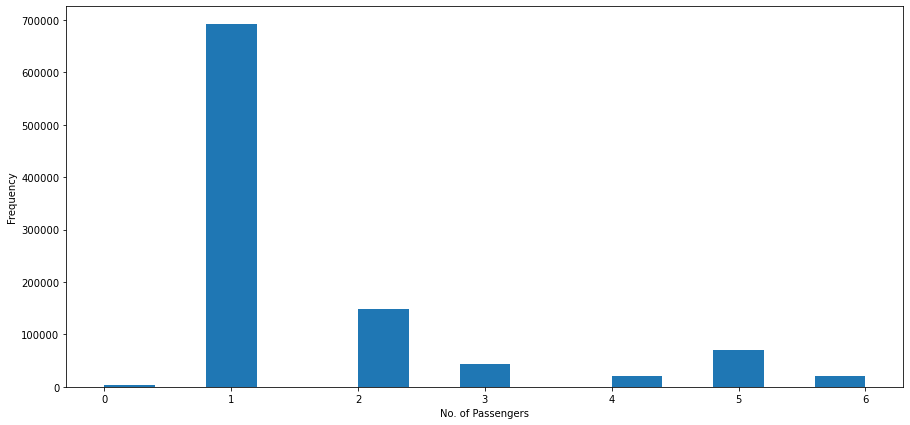

In [46]:
# 승객수별 택시이용 빈도수
plt.figure(figsize=(15,7))
_ = plt.hist(train["passenger_count"], bins=15)
plt.xlabel("No. of Passengers")
plt.ylabel("Frequency")

Text(0, 0.5, 'Fare')

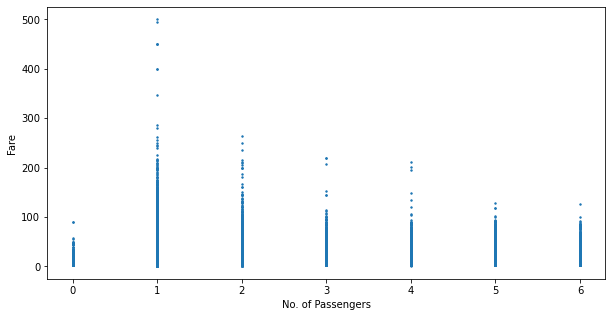

In [53]:
# 승객수별 택시요금
plt.figure(figsize=(10,5))
plt.scatter(x=train["passenger_count"], y=train["fare_amount"],s=2)
plt.xlabel("No. of Passengers")
plt.ylabel("Fare")

* 위의 두 그래프를 보면 1명이 승객인 경우가 가장 많고 가장 높은 요금은 승객수가 1명인 경우로 볼 수 있다.
 따라서, 승객수가 많아질수록 요금도 높아질 것이라는 가설은 맞지 않다.

### Q> pickup 날짜와 시간이 요금에 영향을 미칠까?

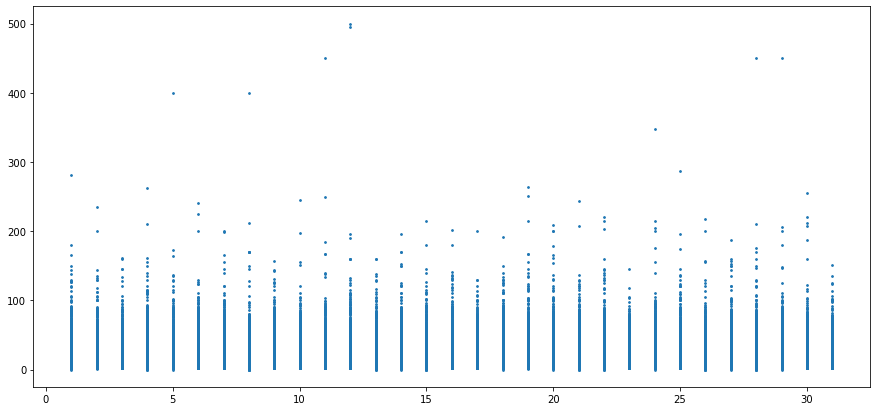

In [57]:
# 날짜별 택시요금
plt.figure(figsize=(15,7))
plt.scatter(x=train["Date"], y=train["fare_amount"], s=3)

* 한달동안 받은 요금은 대부분 균일해보이고 12일에 가장 높은 요금을 받았다.

Text(0, 0.5, 'Frequency')

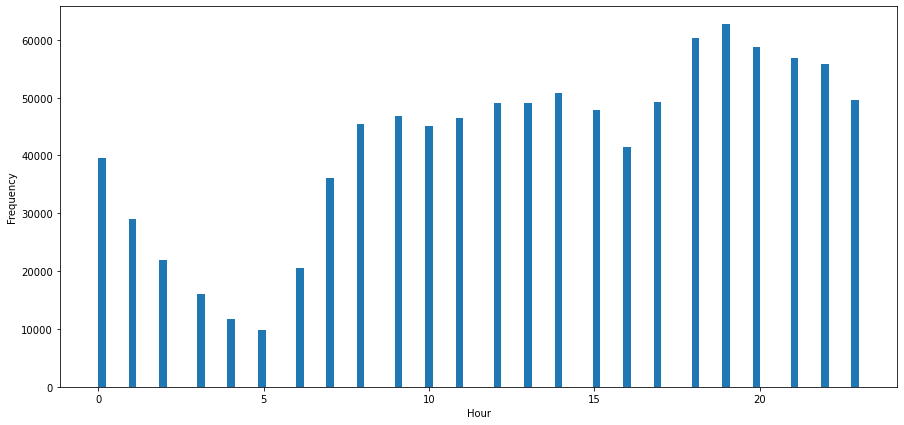

In [58]:
# 시간대별 택시 이용 빈도수
plt.figure(figsize=(15,7))
plt.hist(train["Hour"], bins=100)
plt.xlabel("Hour")
plt.ylabel("Frequency")

* 시간대별로 차이가 뚜렷한걸 보아 시간은 꽤 중요한 역할을 할 것으로 추측해볼 수 있다. 오전 5시에 택시 이용빈도가 가장 낮고 오후 7시에 택시 이용빈도수가 가장 높다.

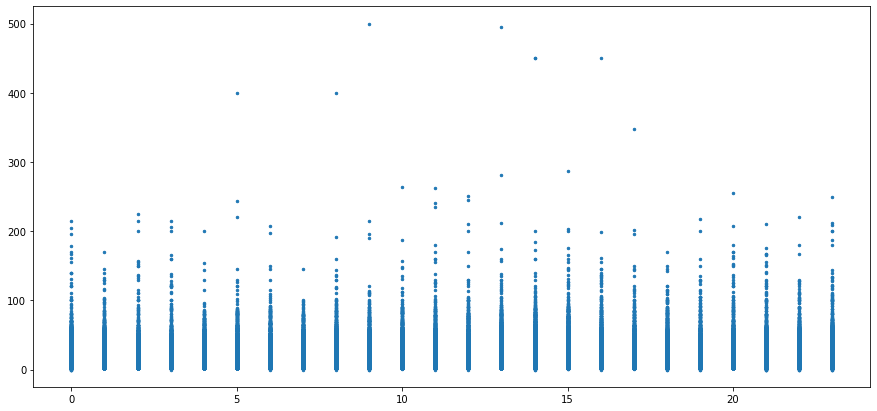

In [62]:
# 시간대별 택시 요금
plt.figure(figsize=(15,7))
plt.scatter(x=train["Hour"], y=train["fare_amount"], s=6)
plt.xlabel("Hour")
plt.ylabel("Fare")

* 반면 요금은 오전 5시에서 오전 10시사이, 오후 2시에서 4시사이에 높은 것을 확인해볼 수 있다.

### Q> 요일이 요금에 영향을 미칠까?

Text(0, 0.5, 'Frequency')

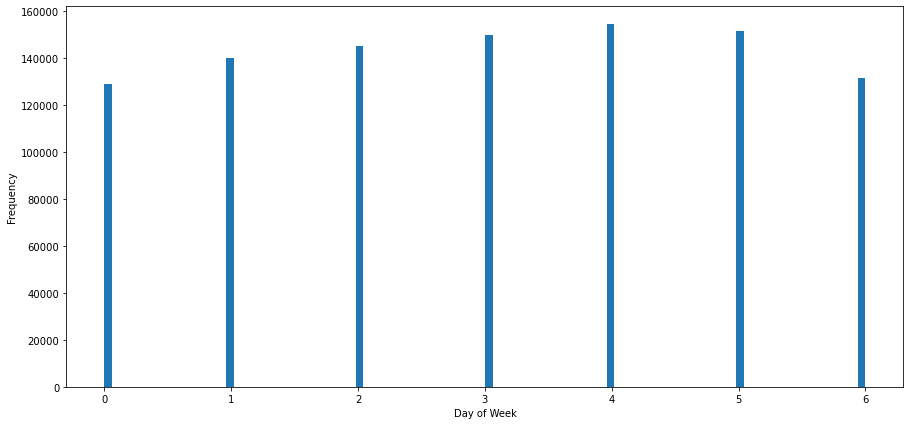

In [63]:
# 요일별 택시 이용 빈도수
plt.figure(figsize=(15,7))
plt.hist(train["Day of Week"], bins=100)
plt.xlabel("Day of Week")
plt.ylabel("Frequency")

* 요일별로 별다른 차이를 보이지 않는다. 그다지 유의미해보이는 변수는 아니다.

Text(0, 0.5, 'Fare')

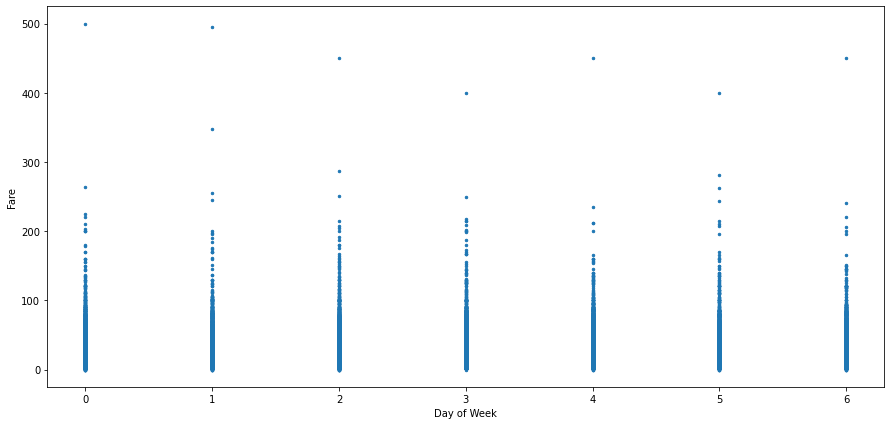

In [65]:
# 요일별 택시요금
plt.figure(figsize=(15,7))
plt.scatter(x=train["Day of Week"], y=train["fare_amount"], s=6)
plt.xlabel("Day of Week")
plt.ylabel("Fare")

* 일요일과 월요일이 택시 요금이 가장 높고 수요일과 금요일이 택시 요금이 가장 낮음을 확인해볼 수 있다.
(이 필사에서는 'Maybe people travel far distances on Sunday and Monday (visiting family and returning back home), and hence, the high fares. And guess people just want to stay at home on a Friday after a hectic week at work, or grab a drink from close by. Hmmm..'이런식으로 해석해 놓은게 흥미로웠다..)


### Q> 주행거리가 요금에 영향을 미칠까?

In [66]:
train.sort_values(["H_Distance", "fare_amount"], ascending=False)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,Year,Month,Date,Day of Week,Hour
793922,2012-06-03 11:19:37.0000002,32.10,2012-06-03 11:19:37+00:00,-73.863359,40.769278,45.581619,-2.013462,2,12594.704725,2012,6,3,6,11
646132,2012-02-08 20:24:00.000000173,10.50,2012-02-08 20:24:00+00:00,-89.439785,1.707957,0.000000,0.000000,1,9945.278008,2012,2,8,2,20
823943,2010-11-14 21:40:00.00000059,4.90,2010-11-14 21:40:00+00:00,0.000000,0.000000,-73.960303,81.510177,1,9747.587427,2010,11,14,6,21
401445,2011-02-26 03:28:03.0000006,14.50,2011-02-26 03:28:03+00:00,0.000000,0.000000,-75.433371,40.752047,1,8786.235625,2011,2,26,5,3
207647,2011-04-19 17:56:04.0000003,38.90,2011-04-19 17:56:04+00:00,0.000000,0.000000,-75.423754,40.773877,1,8785.843243,2011,4,19,1,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
830616,2015-01-21 06:29:21.0000006,0.01,2015-01-21 06:29:21+00:00,0.000000,0.000000,0.000000,0.000000,1,0.000000,2015,1,21,2,6
105051,2013-08-21 21:41:00.000000215,0.00,2013-08-21 21:41:00+00:00,0.000000,0.000000,0.000000,0.000000,2,0.000000,2013,8,21,2,21
331597,2013-08-05 06:45:54.0000005,0.00,2013-08-05 06:45:54+00:00,-73.982354,40.679971,-73.982354,40.679971,1,0.000000,2013,8,5,0,6
436658,2015-03-04 22:33:39.0000008,0.00,2015-03-04 22:33:39+00:00,-74.043442,40.788208,-74.043442,40.788208,1,0.000000,2015,3,4,2,22


In [68]:
len(train)

999911

In [69]:
# 주행거리 구간별로 나눠서 범주형 변수로 바꾸기
bins_0 = train.loc[(train['H_Distance'] == 0), ['H_Distance']]
bins_1 = train.loc[(train['H_Distance'] > 0) & (train['H_Distance'] <= 10),['H_Distance']]
bins_2 = train.loc[(train['H_Distance'] > 10) & (train['H_Distance'] <= 50),['H_Distance']]
bins_3 = train.loc[(train['H_Distance'] > 50) & (train['H_Distance'] <= 100),['H_Distance']]
bins_4 = train.loc[(train['H_Distance'] > 100) & (train['H_Distance'] <= 200),['H_Distance']]
bins_5 = train.loc[(train['H_Distance'] > 200) & (train['H_Distance'] <= 300),['H_Distance']]
bins_6 = train.loc[(train['H_Distance'] > 300),['H_Distance']]
bins_0['bins'] = '0'
bins_1['bins'] = '0-10'
bins_2['bins'] = '11-50'
bins_3['bins'] = '51-100'
bins_4['bins'] = '100-200'
bins_5['bins'] = '201-300'
bins_6['bins'] = '>300'
dist_bins =pd.concat([bins_0,bins_1,bins_2,bins_3,bins_4,bins_5,bins_6])
#len(dist_bins)
dist_bins.columns

Index(['H_Distance', 'bins'], dtype='object')

Text(0, 0.5, 'Frequency')

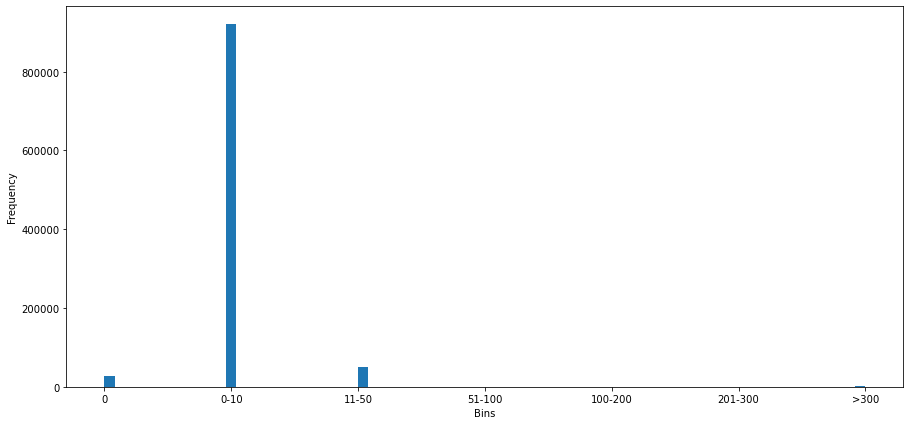

In [71]:
# 주행거리별 빈도수 시각화
plt.figure(figsize=(15,7))
plt.hist(dist_bins["bins"], bins=75)
plt.xlabel("Bins")
plt.ylabel("Frequency")

In [73]:
# 주행거리별 빈도수
Counter(dist_bins["bins"])

Counter({'0': 28481,
         '0-10': 920071,
         '11-50': 49073,
         '51-100': 147,
         '100-200': 206,
         '201-300': 5,
         '>300': 1928})

* 주행거리가 100km 이상인 값들은 이상치 처리하려고 했으나 꽤 많은 값들이 100이상이므로 이는 보류하고 다음과 같은 이상치들을 제거한다.
1. pickup 경도와 위도는 0이고 dropoff 경도와 위도는 0이 아닌데 요금이 0인 경우
2. pickup 경도와 위도는 0이 아니고 dropoff 경도와 위도는 0인데 요금이 0인 경우
3.


In [75]:
# 1. pickup latitude and longitude = 0 & dropoff latitude and longitude != 0
drop1 = train.loc[((train['pickup_latitude']==0) & (train['pickup_longitude']==0))&((train['dropoff_latitude']!=0) & (train['dropoff_longitude']!=0)) & (train['fare_amount']==0)]

In [76]:
train = train.drop(drop1.index, axis=0)
train.shape

(999910, 14)

In [77]:
#1. test 에서도 마찬가지로 이상치 확인 ->x
test.loc[((test['pickup_latitude']==0) & (test['pickup_longitude']==0))&((test['dropoff_latitude']!=0) & (test['dropoff_longitude']!=0))]

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,Year,Month,Date,Day of Week,Hour


In [78]:
# 2. pickup latitude and longitude != 0 & dropoff latitude and longitude = 0
drop2 = train.loc[((train['pickup_latitude']!=0) & (train['pickup_longitude']!=0))&((train['dropoff_latitude']==0) & (train['dropoff_longitude']==0)) & (train['fare_amount']==0)]

In [79]:
train = train.drop(drop2.index, axis=0)
train.shape

(999907, 14)

In [80]:
# 2. tet 에서도 마찬가지로 이상치 확인 -> x
test.loc[((test['pickup_latitude']!=0) & (test['pickup_longitude']!=0))&((test['dropoff_latitude']==0) & (test['dropoff_longitude']==0))]

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,Year,Month,Date,Day of Week,Hour


In [81]:
# 3. 뉴욕안에서 택시를 타고 200km이상 가는건 말이 안됨 -> 이 중 요금이 0원이 아닌거만 보기
# high_dstance 는 주행거리가 200km 이상인거
high_distance = train.loc[(train["H_Distance"]>200)&(train["fare_amount"]!=0)]
high_distance

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,Year,Month,Date,Day of Week,Hour
472,2009-02-22 22:48:00.000000130,2.5,2009-02-22 22:48:00+00:00,0.000000,0.000000,-74.005433,40.726685,2,8667.304968,2009,2,22,6,22
1260,2011-03-10 20:25:00.00000049,5.7,2011-03-10 20:25:00+00:00,-73.973907,40.754743,0.000000,0.000000,2,8665.268588,2011,3,10,3,20
2280,2011-08-29 08:24:00.000000107,8.9,2011-08-29 08:24:00+00:00,-73.936667,40.757815,0.000000,40.757815,1,6026.494216,2011,8,29,0,8
2397,2012-06-24 17:11:10.0000001,45.0,2012-06-24 17:11:10+00:00,0.000000,0.000000,-74.010230,40.714553,2,8667.454421,2012,6,24,6,17
4278,2015-04-07 23:33:02.0000005,7.0,2015-04-07 23:33:02+00:00,-73.972702,40.757423,0.000000,0.000000,1,8665.223767,2015,4,7,1,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997656,2012-01-21 01:43:00.000000134,26.5,2012-01-21 01:43:00+00:00,0.000000,0.000000,-73.954157,40.741552,1,8663.362917,2012,1,21,5,1
997786,2012-02-27 21:12:17.0000003,13.7,2012-02-27 21:12:17+00:00,-73.991041,40.733201,0.000000,0.000000,1,8666.246213,2012,2,27,0,21
998269,2012-10-19 16:56:00.0000003,32.3,2012-10-19 16:56:00+00:00,0.000000,40.750597,-73.863035,40.767178,1,6020.822520,2012,10,19,4,16
998717,2014-07-24 21:48:00.000000155,6.5,2014-07-24 21:48:00+00:00,0.000000,0.000000,-73.991420,40.750400,1,8666.629589,2014,7,24,3,21


* 1929개의 굉장히 많은 데이터가 있음을 알 수 있음. 데이터가 많기도 하고 요금도 있으니까 제거하지 않기로 결정. 대신, 초기 거리 값을 다음 공식을 사용하여 요금을 계산한 거리 값으로 대체 (요금을 위도경도를 사용하면 이상하게 나오는 값이 많으니까 아래 공식을 이용하여 거리를 다시 설정한다는 뜻)
* distance = (fare_amount - 2.5)/1.56
* 뉴욕택시 기본요금 $2.5 , 추가요금 $1.56/km

In [82]:
# distance = (fare_amount - 2.5)/1.56 로 대체 
high_distance['H_Distance'] = high_distance.apply(
    lambda row: (row['fare_amount'] - 2.50)/1.56,
    axis=1
)

/var/folders/b9/tj0xrps92c72qmrbfg4n9jb00000gn/T/ipykernel_2206/702157327.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  high_distance['H_Distance'] = high_distance.apply(


In [83]:
high_distance

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,Year,Month,Date,Day of Week,Hour
472,2009-02-22 22:48:00.000000130,2.5,2009-02-22 22:48:00+00:00,0.000000,0.000000,-74.005433,40.726685,2,0.000000,2009,2,22,6,22
1260,2011-03-10 20:25:00.00000049,5.7,2011-03-10 20:25:00+00:00,-73.973907,40.754743,0.000000,0.000000,2,2.051282,2011,3,10,3,20
2280,2011-08-29 08:24:00.000000107,8.9,2011-08-29 08:24:00+00:00,-73.936667,40.757815,0.000000,40.757815,1,4.102564,2011,8,29,0,8
2397,2012-06-24 17:11:10.0000001,45.0,2012-06-24 17:11:10+00:00,0.000000,0.000000,-74.010230,40.714553,2,27.243590,2012,6,24,6,17
4278,2015-04-07 23:33:02.0000005,7.0,2015-04-07 23:33:02+00:00,-73.972702,40.757423,0.000000,0.000000,1,2.884615,2015,4,7,1,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
997656,2012-01-21 01:43:00.000000134,26.5,2012-01-21 01:43:00+00:00,0.000000,0.000000,-73.954157,40.741552,1,15.384615,2012,1,21,5,1
997786,2012-02-27 21:12:17.0000003,13.7,2012-02-27 21:12:17+00:00,-73.991041,40.733201,0.000000,0.000000,1,7.179487,2012,2,27,0,21
998269,2012-10-19 16:56:00.0000003,32.3,2012-10-19 16:56:00+00:00,0.000000,40.750597,-73.863035,40.767178,1,19.102564,2012,10,19,4,16
998717,2014-07-24 21:48:00.000000155,6.5,2014-07-24 21:48:00+00:00,0.000000,0.000000,-73.991420,40.750400,1,2.564103,2014,7,24,3,21


In [84]:
train.update(high_distance)

In [85]:
train.shape

(999907, 14)

### 주행거리가 0인 데이터

In [86]:
# 주행거리가 0인 데이터
train[train["H_Distance"]==0]

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,Year,Month,Date,Day of Week,Hour
11,2012-12-24 11:24:00.00000098,5.5,2012-12-24 11:24:00+00:00,0.000000,0.000000,0.000000,0.000000,3.0,0.0,2012.0,12.0,24.0,0.0,11.0
15,2013-11-23 12:57:00.000000190,5.0,2013-11-23 12:57:00+00:00,0.000000,0.000000,0.000000,0.000000,1.0,0.0,2013.0,11.0,23.0,5.0,12.0
26,2011-02-07 20:01:00.000000114,6.5,2011-02-07 20:01:00+00:00,0.000000,0.000000,0.000000,0.000000,1.0,0.0,2011.0,2.0,7.0,0.0,20.0
105,2009-03-25 00:08:52.0000001,52.0,2009-03-25 00:08:52+00:00,-74.035839,40.747320,-74.035839,40.747320,1.0,0.0,2009.0,3.0,25.0,2.0,0.0
124,2013-01-17 17:22:00.00000043,8.0,2013-01-17 17:22:00+00:00,0.000000,0.000000,0.000000,0.000000,2.0,0.0,2013.0,1.0,17.0,3.0,17.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999888,2010-04-28 21:08:00.00000038,9.3,2010-04-28 21:08:00+00:00,0.000000,0.000000,0.000000,0.000000,3.0,0.0,2010.0,4.0,28.0,2.0,21.0
999915,2014-05-12 02:34:05.0000001,8.0,2014-05-12 02:34:05+00:00,0.000000,0.000000,0.000000,0.000000,2.0,0.0,2014.0,5.0,12.0,0.0,2.0
999931,2012-03-05 22:22:00.000000181,6.9,2012-03-05 22:22:00+00:00,-73.970005,40.713008,-73.970005,40.713008,5.0,0.0,2012.0,3.0,5.0,0.0,22.0
999988,2011-05-14 07:21:00.00000014,25.3,2011-05-14 07:21:00+00:00,-73.937393,40.757975,-73.937393,40.757975,5.0,0.0,2011.0,5.0,14.0,5.0,7.0


#### 시나리오1. 주행거리가 0이고 요금도 0 
* -> 데이터에 영향을 미치지 않으므로 제거

In [88]:
drop = train[(train["H_Distance"]==0)&(train["fare_amount"]==0)]
drop

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,Year,Month,Date,Day of Week,Hour
105051,2013-08-21 21:41:00.000000215,0.0,2013-08-21 21:41:00+00:00,0.000000,0.000000,0.000000,0.000000,2.0,0.0,2013.0,8.0,21.0,2.0,21.0
331597,2013-08-05 06:45:54.0000005,0.0,2013-08-05 06:45:54+00:00,-73.982354,40.679971,-73.982354,40.679971,1.0,0.0,2013.0,8.0,5.0,0.0,6.0
436658,2015-03-04 22:33:39.0000008,0.0,2015-03-04 22:33:39+00:00,-74.043442,40.788208,-74.043442,40.788208,1.0,0.0,2015.0,3.0,4.0,2.0,22.0
689250,2015-05-27 23:10:03.0000004,0.0,2015-05-27 23:10:03+00:00,-73.994125,40.741131,-73.994125,40.741131,1.0,0.0,2015.0,5.0,27.0,2.0,23.0


In [89]:
# 이상치 제거
train = train.drop(drop.index, axis=0)
train.shape

(999903, 14)

#### 시나리오2. 기본요금보다 요금이 적고 주행거리가 0
* -> 기본요금보다 적은게 말이안됨. 제거

A quick Google search gave me the following prices -

$$2.5 base-price + $1.56/km --> 6AM to 8PM Mon-Fri

$$3.0 base-price + $1.56/km --> 8PM to 6AM Mon-Fri and Sat&Sun

In [90]:
#2-1. 6AM to 8PM Mon-Fri
rush_hour = train.loc[(((train['Hour']>=6)&(train['Hour']<=20)) & ((train['Day of Week']>=1) & (train['Day of Week']<=5)) & (train['H_Distance']==0) & (train['fare_amount'] < 2.5))]
rush_hour

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,Year,Month,Date,Day of Week,Hour
830616,2015-01-21 06:29:21.0000006,0.01,2015-01-21 06:29:21+00:00,0.0,0.0,0.0,0.0,1.0,0.0,2015.0,1.0,21.0,2.0,6.0
925892,2015-01-21 14:12:00.0000004,1.90,2015-01-21 14:12:00+00:00,0.0,0.0,0.0,0.0,1.0,0.0,2015.0,1.0,21.0,2.0,14.0


In [91]:
train = train.drop(rush_hour.index, axis=0)
train.shape

(999901, 14)

In [94]:
#2-2. 8PM to 6AM Mon-Fri and Sat&Sun
non_rush_hour = train.loc[(((train['Hour']<6)|(train['Hour']>20)) & ((train['Day of Week']>=1)&(train['Day of Week']<=5)) & (train['H_Distance']==0) & (train['fare_amount'] < 3.0) )]
non_rush_hour

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,Year,Month,Date,Day of Week,Hour
376,2014-05-29 05:57:22.0000001,2.5,2014-05-29 05:57:22+00:00,0.000000,0.000000,0.000000,0.000000,1.0,0.0,2014.0,5.0,29.0,3.0,5.0
503,2010-01-19 01:10:00.00000012,2.5,2010-01-19 01:10:00+00:00,-73.998720,40.624708,-73.998720,40.624708,1.0,0.0,2010.0,1.0,19.0,1.0,1.0
657,2009-08-25 01:50:21.0000001,2.5,2009-08-25 01:50:21+00:00,-73.986410,40.763350,-73.986410,40.763350,1.0,0.0,2009.0,8.0,25.0,1.0,1.0
3168,2012-07-06 22:07:00.000000111,2.5,2012-07-06 22:07:00+00:00,0.000000,0.000000,0.000000,0.000000,1.0,0.0,2012.0,7.0,6.0,4.0,22.0
12953,2010-07-23 03:30:08.0000001,2.9,2010-07-23 03:30:08+00:00,0.000000,0.000000,0.000000,0.000000,1.0,0.0,2010.0,7.0,23.0,4.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
981827,2013-07-11 01:24:12.0000001,2.5,2013-07-11 01:24:12+00:00,-73.989207,40.718738,-73.989207,40.718738,1.0,0.0,2013.0,7.0,11.0,3.0,1.0
982760,2013-08-15 02:36:09.0000002,2.5,2013-08-15 02:36:09+00:00,0.000000,0.000000,0.000000,0.000000,1.0,0.0,2013.0,8.0,15.0,3.0,2.0
991940,2009-11-18 23:23:55.0000002,2.5,2009-11-18 23:23:55+00:00,-73.982666,40.756720,-73.982666,40.756720,1.0,0.0,2009.0,11.0,18.0,2.0,23.0
994174,2015-03-19 21:34:53.0000007,2.5,2015-03-19 21:34:53+00:00,0.000000,0.000000,0.000000,0.000000,1.0,0.0,2015.0,3.0,19.0,3.0,21.0


* 흠 그래도 기본요금 2.5는 넘으니까 제거하지 않겠음

In [95]:
#2-3. Saturday and Sunday all hours
weekends = train.loc[((train['Day of Week']==0) | (train['Day of Week']==6)) & (train['H_Distance']==0) & (train['fare_amount'] < 3.0)]
weekends

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,Year,Month,Date,Day of Week,Hour
472,2009-02-22 22:48:00.000000130,2.5,2009-02-22 22:48:00+00:00,0.000000,0.000000,-74.005433,40.726685,2.0,0.0,2009.0,2.0,22.0,6.0,22.0
1419,2013-07-21 00:10:23.0000001,2.5,2013-07-21 00:10:23+00:00,-73.956556,40.779828,-73.956556,40.779828,1.0,0.0,2013.0,7.0,21.0,6.0,0.0
1774,2012-08-27 15:24:00.0000007,2.5,2012-08-27 15:24:00+00:00,-73.950282,40.701282,-73.950282,40.701282,1.0,0.0,2012.0,8.0,27.0,0.0,15.0
4367,2014-01-13 16:14:48.0000001,2.5,2014-01-13 16:14:48+00:00,-73.948410,40.744969,-73.948410,40.744969,1.0,0.0,2014.0,1.0,13.0,0.0,16.0
4954,2010-01-10 13:44:35.0000007,2.5,2010-01-10 13:44:35+00:00,-73.983934,40.754938,-73.983934,40.754938,1.0,0.0,2010.0,1.0,10.0,6.0,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
985217,2009-02-22 06:16:56.0000003,2.5,2009-02-22 06:16:56+00:00,-73.992602,40.763705,-73.992602,40.763705,1.0,0.0,2009.0,2.0,22.0,6.0,6.0
990173,2009-11-01 14:37:13.0000001,2.5,2009-11-01 14:37:13+00:00,-73.996724,40.764173,-73.996724,40.764173,1.0,0.0,2009.0,11.0,1.0,6.0,14.0
994092,2012-02-27 07:36:00.000000150,2.5,2012-02-27 07:36:00+00:00,0.000000,0.000000,0.000000,0.000000,1.0,0.0,2012.0,2.0,27.0,0.0,7.0
996710,2010-09-27 21:54:00.00000054,2.5,2010-09-27 21:54:00+00:00,-73.983942,40.744048,-73.983942,40.744048,1.0,0.0,2010.0,9.0,27.0,0.0,21.0


* 흠 이것도 기본요금 2.5는 넘으니까 제거하지 않겠음

#### 시나리오3. 요금은 0인데 주행거리는 0이 아닌 경우
* fare = 2.5 + 1.56(H_Distance)

In [97]:
# 요금은 0인데 주행거리는 0이 아닌 데이터
scenario_3 = train.loc[(train['H_Distance']!=0) & (train['fare_amount']==0)]
len(scenario_3) 

21

In [98]:
scenario_3.sort_values('H_Distance', ascending=False)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,H_Distance,Year,Month,Date,Day of Week,Hour
788466,2010-02-26 22:10:53.0000002,0.0,2010-02-26 22:10:53+00:00,-73.812794,40.695922,-73.993577,40.749743,1.0,16.368200,2010.0,2.0,26.0,4.0,22.0
762802,2015-02-04 23:47:28.0000006,0.0,2015-02-04 23:47:28+00:00,-73.864532,40.770012,-74.030937,40.727139,1.0,14.806275,2015.0,2.0,4.0,2.0,23.0
561786,2013-08-26 00:22:00.00000058,0.0,2013-08-26 00:22:00+00:00,-73.988468,40.722775,-73.923687,40.807775,1.0,10.913162,2013.0,8.0,26.0,0.0,0.0
10002,2010-02-15 14:26:01.0000003,0.0,2010-02-15 14:26:01+00:00,-73.987115,40.738808,-74.005911,40.713960,1.0,3.184763,2010.0,2.0,15.0,0.0,14.0
431819,2015-01-13 00:48:21.0000001,0.0,2015-01-13 00:48:21+00:00,-73.998383,40.759418,-74.031189,40.748924,1.0,2.999630,2015.0,1.0,13.0,1.0,0.0
895361,2010-02-08 23:39:17.0000002,0.0,2010-02-08 23:39:17+00:00,-73.880422,40.741431,-73.873903,40.742301,1.0,0.557666,2010.0,2.0,8.0,0.0,23.0
386734,2015-05-08 07:02:38.0000001,0.0,2015-05-08 07:02:38+00:00,-73.999496,40.748787,-74.002556,40.744659,1.0,0.526370,2015.0,5.0,8.0,4.0,7.0
520715,2015-03-28 18:14:09.00000011,0.0,2015-03-28 18:14:09+00:00,-73.987694,40.764881,-73.990150,40.761581,4.0,0.421227,2015.0,3.0,28.0,5.0,18.0
760662,2015-05-24 03:16:52.0000002,0.0,2015-05-24 03:16:52+00:00,-74.001633,40.730762,-73.999748,40.733494,1.0,0.342713,2015.0,5.0,24.0,6.0,3.0
47302,2010-03-18 19:13:39.0000002,0.0,2010-03-18 19:13:39+00:00,-73.942346,40.806269,-73.942463,40.806129,1.0,0.018420,2010.0,3.0,18.0,3.0,19.0


* 주행거리를 보니까 이상치인 값이 없음 -> 요금 공식을 이용하여 요금 채워주기

In [99]:
# 주행거리가 0인 데이터들 요금 구해서 넣어주기
scenario_3['fare_amount'] = scenario_3.apply(
    lambda row: ((row['H_Distance'] * 1.56) + 2.50), axis=1
)
scenario_3['fare_amount']

/var/folders/b9/tj0xrps92c72qmrbfg4n9jb00000gn/T/ipykernel_2206/2596190451.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scenario_3['fare_amount'] = scenario_3.apply(


10002      7.468230
27891      2.501660
47302      2.528736
175352     2.514421
211455     2.509022
211499     2.500838
266485     2.505469
386734     3.321137
431819     7.179423
489767     2.501201
495273     2.500662
520715     3.157114
561786    19.524533
670254     2.500662
681342     2.501577
760662     3.034632
762802    25.597788
788466    28.034391
895361     3.369958
938020     2.501202
957590     2.505506
Name: fare_amount, dtype: float64

In [100]:
train.update(scenario_3)

In [101]:
train.shape

(999901, 14)

#### 2-4 요금은 0이 아닌데 주행거리가 0
*  distance = (fare_amount - 2.5)/1.56

In [102]:
#요금은 0이 아닌데 주행거리가 0
scenario_4 = train.loc[(train['H_Distance']==0) & (train['fare_amount']!=0)]
len(scenario_4)

28661

In [103]:
# 이 중 요금이 기본요금 이상인 값만 가져오기
scenario_4_sub = scenario_4.loc[(scenario_4['fare_amount']>3.0)&(scenario_4['H_Distance']==0)]
len(scenario_4_sub)

27159

In [104]:
# 위와 마찬가지로 거리공식을 이용하여 값 계산한 뒤에 주행거리 값 대체해주기
scenario_4_sub['H_Distance'] = scenario_4_sub.apply(
lambda row: ((row['fare_amount']-2.50)/1.56), axis=1
)

/var/folders/b9/tj0xrps92c72qmrbfg4n9jb00000gn/T/ipykernel_2206/385517987.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scenario_4_sub['H_Distance'] = scenario_4_sub.apply(


In [105]:
train.update(scenario_4_sub)
train.shape

(999901, 14)

## Modelling and prediction

In [107]:
# train 컬럼 확인
train.columns

Index(['key', 'fare_amount', 'pickup_datetime', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'passenger_count', 'H_Distance', 'Year', 'Month', 'Date', 'Day of Week',
       'Hour'],
      dtype='object')

In [108]:
# test 컬럼 확인
test.columns

Index(['key', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'H_Distance', 'Year', 'Month', 'Date', 'Day of Week', 'Hour'],
      dtype='object')

In [109]:
# 필요없는 컬럼 제거
train = train.drop(['key','pickup_datetime'], axis=1)
test = test.drop(['key','pickup_datetime'], axis=1)

In [110]:
# X_train
X_train = train.iloc[:,train.columns!="fare_amount"]
X_train.shape

(999901, 11)

In [111]:
X_test = test
X_test.shape

(9914, 11)

In [113]:
y_train = train["fare_amount"]
y_train.shape

(999901,)

### 랜덤포레스트 회귀분석

In [134]:
### 랜덤포레스트 회귀분석
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()
rf.fit(X_train, y_train)

KeyboardInterrupt: 

In [ ]:
rf_predict = rf.predict(X_test)
rf_predict

In [ ]:
# 답안저장
submission = pd.read_csv("data/taxi/sample_submission.csv")
submission["fare_amount"] = rf_predict
submission.to_csv("data/taxi/submission_rf.csv", index=False)
pd.read_csv("data/taxi/submission_rf.csv")

### LGBM

In [117]:
# LGBM
import lightgbm as lgbm

In [118]:
# 하이퍼파라미터
params = {
        'boosting_type':'gbdt',
        'objective': 'regression',
        'nthread': -1,
        'verbose': 0,
        'num_leaves': 31,
        'learning_rate': 0.05,
        'max_depth': 1,
        'subsample': 0.8,
        'subsample_freq': 1,
        'colsample_bytree': 0.6,
        'reg_aplha': 1,
        'reg_lambda': 0.001,
        'metric': 'rmse',
        'min_split_gain': 0.5,
        'min_child_weight': 1,
        'min_child_samples': 10,
        'scale_pos_weight':1     
    }

In [119]:
pred_test_y = np.zeros(X_test.shape[0])
pred_test_y.shape

(9914,)

In [122]:
train_set = lgbm.Dataset(X_train, y_train, silent=True)
train_set

In [123]:
# num_boost_round: boosting을 얼마나 돌릴지
model = lgbm.train(params, train_set = train_set, num_boost_round=300)
print(model)

/Users/kwonsojung/opt/anaconda3/lib/python3.9/site-packages/lightgbm/basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] Unknown parameter: reg_aplha
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: reg_aplha
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007606 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.


In [124]:
# 예측
pred_test_y = model.predict(X_test, num_iteration = model.best_iteration)
print(pred_test_y)

[ 8.1981973   8.53477465  4.9959965  ... 45.29399368 20.97271032
  7.41365799]


In [126]:
# 답안 저장
submission = pd.read_csv("data/taxi/sample_submission.csv")
submission['fare_amount'] = pred_test_y
submission.to_csv('data/taxi/submission_LGBM.csv', index=False)
pd.read_csv("data/taxi/submission_LGBM.csv")

,key,fare_amount
0,2015-01-27 13:08:24.0000002,8.198197
1,2015-01-27 13:08:24.0000003,8.534775
2,2011-10-08 11:53:44.0000002,4.995997
3,2012-12-01 21:12:12.0000002,7.640134
4,2012-12-01 21:12:12.0000003,13.891320
...,...,...
9909,2015-05-10 12:37:51.0000002,9.238950
9910,2015-01-12 17:05:51.0000001,11.235000
9911,2015-04-19 20:44:15.0000001,45.293994
9912,2015-01-31 01:05:19.0000005,20.972710


### XGBM

In [127]:
#XGBM
import xgboost as xgb

/Users/kwonsojung/opt/anaconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [128]:
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test)
dtrain

/Users/kwonsojung/opt/anaconda3/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [129]:
# 하이퍼파라미터
params = {'max_depth':7,
          'eta':1,
          'silent':1,
          'objective':'reg:linear',
          'eval_metric':'rmse',
          'learning_rate':0.05,
         }
num_rounds = 50

In [130]:
xb = xgb.train(params, dtrain, num_rounds)

[19:37:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[19:37:35] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [131]:
y_pred_xgb = xb.predict(dtest)
print(y_pred_xgb)

[ 7.795204   8.047973   4.5814323 ... 42.70728   16.297667   6.336797 ]


In [133]:
# 답안저장
submission['fare_amount'] = y_pred_xgb
submission.to_csv('data/taxi/submission_XGBM.csv', index=False)
pd.read_csv("data/taxi/submission_XGBM.csv")

,key,fare_amount
0,2015-01-27 13:08:24.0000002,7.795204
1,2015-01-27 13:08:24.0000003,8.047973
2,2011-10-08 11:53:44.0000002,4.581432
3,2012-12-01 21:12:12.0000002,6.665927
4,2012-12-01 21:12:12.0000003,12.298733
...,...,...
9909,2015-05-10 12:37:51.0000002,8.151809
9910,2015-01-12 17:05:51.0000001,10.362726
9911,2015-04-19 20:44:15.0000001,42.707280
9912,2015-01-31 01:05:19.0000005,16.297667
